# Chapter 12 - Implementing a Multi-layer Artificial Neural Network from Scratch

#### mnist数据集介绍
The MNIST dataset is publicly available at `http://yann.lecun.com/exdb/mnist/` and consists of the
following four parts:
1. Training dataset images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, and 60,000 examples)
2. Training dataset labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, and 60,000 labels)
3. Test dataset images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB unzipped, and 10,000 examples)
4. Test dataset labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, and 10,000 labels)

In [1]:
import os
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels

In [2]:
path = '../datasets/mnist'

X_train, y_train = load_mnist(path, kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [3]:
784 ** 0.5

28.0

In [4]:
X_test, y_test = load_mnist(path, kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [5]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Visualize the first digit of each class

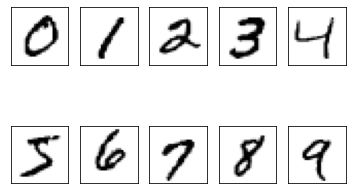

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, sharex=True, sharey=True)
ax = ax.flatten()  #仅仅将ax的索引展平，从而可以使用一维索引(否则使用二维索引)，但不影响画图位置
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
# plt.savefig('images/12_5.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

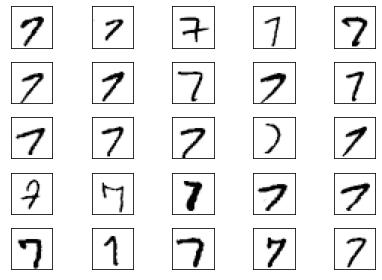

In [7]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
ax = ax.flatten()  #仅仅将ax的索引展平，从而可以使用一维索引(否则使用二维索引)，但不影响画图位置
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('images/12_6.png', dpi=300)
plt.show()

## Implementing a multi-layer perceptron

In [10]:
import sys

class NeuralNetMLP:
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0.)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default: 1)
        Number of training examples per minibatch.
    seed : int (default: None)
        Random seed for initializing weights and shuffling.

    Attributes
    -----------
    eval_ : dict
      Dictionary collecting the cost, training accuracy,
      and validation accuracy for each epoch during training.

    """

    def __init__(self, n_hidden=30,
                 l2=0, epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=32, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        
        Parameters
        ------------
        y : array, shape = [n_examples]
            Target values.
        n_classes : int
            Number of classes

        Returns
        -----------
        onehot : array, shape = (n_examples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for i, val in enumerate(y):
            onehot[val, i] = 1
        return onehot.T

    def _sigmoid(self, z):
        """Activation function (sigmoid)"""
        return 1 / (1 + np.exp(-z))

    def _forward(self, X):
        """Compute forward propagation"""

        # step 1: net input of hidden layer
        # [n_examples, n_features] dot [n_features, n_hiden]
        # -> [n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_examples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_examples, n_calsslabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_examples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_examples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = self.l2 * (np.sum(self.w_h ** 2) + np.sum(self.w_out ** 2))

        term1 = -y_enc * np.log(output)
        term2 = -(1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 + term2) + L2_term

        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)

        return cost

    def predict(self, X):
        """Predict class labels

        Parameters
        ----------
        X : array, shape = [n_examples, n_features]
            Input layer with original features.

        Returns
        -------
        y_pred : array, shape = [n_examples]
            Predicted class labels.
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """ Learn weights from training data.

        Parameters
        -----------
        X_train : array, shape = [n_examples, n_features]
            Input layer with original features.
        y_train : array, shape = [n_examples]
            Target class labels.
        X_valid : array, shape = [n_examples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_examples]
            Sample labels for validation during training

        Returns:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # Weight initialization
        ########################

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                      1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backpropagation
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)

            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            print('%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            # sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self


In [11]:
n_epochs = 200

nn = NeuralNetMLP(n_hidden=100,
                  l2=0.01,
                  epochs=n_epochs,
                  eta=0.0005,
                  minibatch_size=100,
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000],
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

001/200 | Cost: 66739.71 | Train/Valid Acc.: 84.53%/88.86% 
002/200 | Cost: 47830.40 | Train/Valid Acc.: 88.34%/91.74% 
003/200 | Cost: 40336.64 | Train/Valid Acc.: 89.64%/92.70% 
004/200 | Cost: 36066.12 | Train/Valid Acc.: 90.55%/93.12% 
005/200 | Cost: 33432.26 | Train/Valid Acc.: 91.11%/93.42% 
006/200 | Cost: 31197.73 | Train/Valid Acc.: 91.72%/93.76% 
007/200 | Cost: 29736.45 | Train/Valid Acc.: 92.10%/94.14% 
008/200 | Cost: 28197.88 | Train/Valid Acc.: 92.54%/94.28% 
009/200 | Cost: 26990.73 | Train/Valid Acc.: 92.88%/94.68% 
010/200 | Cost: 25941.66 | Train/Valid Acc.: 93.08%/94.96% 
011/200 | Cost: 25213.82 | Train/Valid Acc.: 93.22%/94.86% 
012/200 | Cost: 24237.90 | Train/Valid Acc.: 93.63%/94.98% 
013/200 | Cost: 23398.20 | Train/Valid Acc.: 93.86%/95.18% 
014/200 | Cost: 22941.42 | Train/Valid Acc.: 93.92%/95.30% 
015/200 | Cost: 22316.23 | Train/Valid Acc.: 94.21%/95.64% 
016/200 | Cost: 21520.40 | Train/Valid Acc.: 94.34%/95.64% 
017/200 | Cost: 21130.86 | Train/Valid A

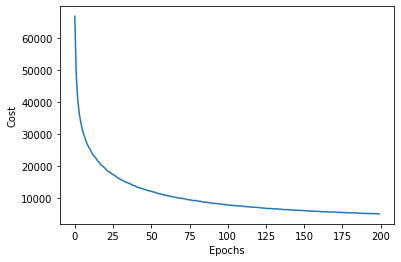

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

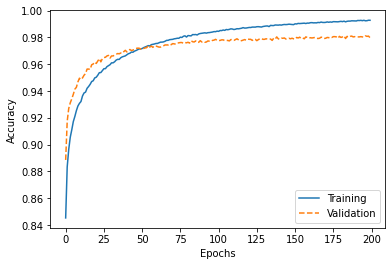

In [13]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
# plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [14]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


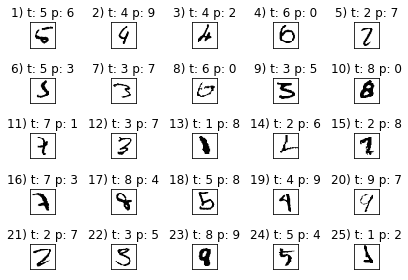

In [15]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('images/12_09.png', dpi=300)
plt.show()

# 第二种：最后一层用softmax，损失用交叉熵损失

In [ ]:
import numpy as np


# Sine sample dataset
def create_data(samples=1000):
    X = np.arange(samples).reshape(-1, 1) / samples
    y = np.sin(2 * np.pi * X).reshape(-1, 1)

    return X, y


X, y = create_data()

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X, y)

In [ ]:
import numpy as np


# Copyright (c) 2015 Andrej Karpathy
# License: https://github.com/cs231n/cs231n.github.io/blob/master/LICENSE
# Source: https://cs231n.github.io/neural-networks-case-study/
def create_data(samples, classes):
    X = np.zeros((samples*classes, 2))
    y = np.zeros(samples*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(samples*class_number, samples*(class_number+1))
        r = np.linspace(0.0, 1, samples)
        t = np.linspace(class_number*4, (class_number+1)*4, samples) + np.random.randn(samples)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

X, y = create_data(100, 3)

In [ ]:
X

In [ ]:
type(y)

In [ ]:
y.shape

In [ ]:
C = np.max(X, axis=1, keepdims=True)
C

In [ ]:
D = X - C
D

In [ ]:
E = np.max(X, axis=1)
E

In [ ]:
F = X - E
F

In [ ]:
A = np.ones((3, 4, 5, 6))
B = np.ones((5, 6)) + 1
C = A - B
C

In [ ]:
np.unique(C)

In [ ]:
np.eye(3)

In [ ]:
np.eye(3, 4)

In [ ]:
softmax_output = [0.7, 0.1, 0.2]
softmax_output = np.array(softmax_output).reshape(-1, 1)
softmax_output

In [ ]:
np.diagflat()